In [1]:
import os

import vizdoom

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

(307, 240, 320, 3)
(1, 60, 80, 3)


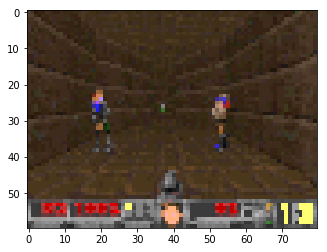

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 60, 80, 3)


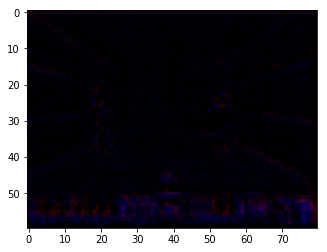

In [12]:
path = os.path.join("vizdoom_dataset")
file = np.load(path+"\\states0.npy", allow_pickle=True)
print(file.shape)

test_max_pool = keras.layers.MaxPooling2D(2)(file[10][np.newaxis])
again = keras.layers.MaxPooling2D(2)(test_max_pool)
#again = keras.layers.MaxPooling2D(2)(again)

print(again.shape)
plt.imshow(again[0])
plt.show()

test_conv2d = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="same",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Conv2D(3, kernel_size=1, strides=1, padding="same")
])(file[10][np.newaxis])

print(test_conv2d.shape)

plt.imshow(test_conv2d[0])
plt.show()



In [3]:
rewards = np.load(path+"\\rewards0.npy", allow_pickle=True)

def load_random_data():
    
    random_video = 0
    path = os.path.join("vizdoom_dataset")
    states = np.load(path+"\\states{}.npy".format(random_video), allow_pickle=True)
    actions = np.load(path+"\\actions{}.npy".format(random_video), allow_pickle=True)
    rewards = np.load(path+"\\rewards{}.npy".format(random_video), allow_pickle=True)
    n_states = np.load(path+"\\n_states{}.npy".format(random_video), allow_pickle=True)
    dones = np.load(path+"\\dones{}.npy".format(random_video), allow_pickle=True)
    
    video_len = dones.shape[0]
    random_video_index = np.random.randint(video_len-1)
    
    return states, actions, rewards, n_states, dones, random_video_index

load_random_data()

(array([[[[0.2       , 0.16862746, 0.07450981],
          [0.2       , 0.16862746, 0.07450981],
          [0.2784314 , 0.2       , 0.13725491],
          ...,
          [0.2627451 , 0.18431373, 0.10588235],
          [0.2627451 , 0.18431373, 0.10588235],
          [0.21568628, 0.13725491, 0.07450981]],
 
         [[0.2627451 , 0.18431373, 0.10588235],
          [0.2       , 0.16862746, 0.07450981],
          [0.21568628, 0.13725491, 0.07450981],
          ...,
          [0.21568628, 0.13725491, 0.07450981],
          [0.21568628, 0.13725491, 0.07450981],
          [0.21568628, 0.13725491, 0.07450981]],
 
         [[0.2627451 , 0.18431373, 0.10588235],
          [0.2627451 , 0.18431373, 0.10588235],
          [0.21568628, 0.13725491, 0.07450981],
          ...,
          [0.21568628, 0.13725491, 0.07450981],
          [0.21568628, 0.13725491, 0.07450981],
          [0.21568628, 0.13725491, 0.07450981]],
 
         ...,
 
         [[0.07450981, 0.07450981, 0.07450981],
          [0.07450

In [4]:
input_shape = (240, 320, 3)
n_outputs = 7

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=8, strides=4, padding="same", input_shape=input_shape),
    keras.layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, strides=1, padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(n_outputs)
])

target_model = keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

In [5]:
def find_n_step_return(states, rewards, dones, random_video_index):
    frames_left = dones.shape[0] - random_video_index
    gamma = 0.95
    n_step_return = 0

    if frames_left < 10:
        n = frames_left
    else:
        n = 10

    n_step_state = states[random_video_index + n]

    for i in range(n):
        n_step_return += (gamma**i) * (rewards[random_video_index + i])

    print(n_step_return)

    n_step_return += (gamma ** n) * np.max(model(n_step_state[np.newaxis]))

    print(n_step_return)
    return n_step_return

In [43]:
def training_step(target_model, model):
    discount_factor = 0.95
    loss_fn = keras.losses.mean_squared_error
    optimizer = keras.optimizers.Adam(lr=1e-3)
    
    states, actions, rewards, n_states, dones, rand_idx = load_random_data()
    next_Q_values = target_model.predict(n_states[rand_idx][np.newaxis])
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards[rand_idx] + 
                      (1 - dones[rand_idx]) * discount_factor * max_next_Q_values)
    mask = actions[rand_idx]
    
    plt.imshow(states[rand_idx])
    plt.show()
    
    plt.imshow(n_states[rand_idx])
    plt.show()
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) + find_n_step_return(states, rewards, dones, rand_idx)
        print(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [45]:
def train_model(target_model, model, n_epochs=50):
    for epoch in range(n_epochs):
        print(epoch)
        training_step(target_model, model)
        
train_model(target_model, model)

0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\robin\anaconda3\envs\env_pytorch\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-bff753406e6c>", line 6, in <module>
    train_model(target_model, model)
  File "<ipython-input-45-bff753406e6c>", line 4, in train_model
    training_step(target_model, model)
  File "<ipython-input-43-8c3b6826ed48>", line 7, in training_step
    next_Q_values = target_model.predict(n_states[rand_idx][np.newaxis])
  File "c:\users\robin\anaconda3\envs\env_pytorch\lib\site-packages\tensorflow\python\keras\engine\training.py", line 130, in _method_wrapper
    return method(self, *args, **kwargs)
  File "c:\users\robin\anaconda3\envs\env_pytorch\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1563, in predict
    self._check_call_args('predict')
  File "c:\users\robin\anaconda3\envs\env_pytorch\lib\site-packages\tensorflow\python\k

TypeError: object of type 'NoneType' has no len()